# 항공사 지연 요인 분석 보고서
## 1. 프로젝트 개요
- 분석 목적: 항공사의 지연 요인(운항사, 관제, 기상)을 파악하여 개선 방향 제시
- 데이터 출처: 항공 운항 지연률 데이터 (총 33,468건)
- 분석 대상 변수:
    - pct_carrier_delay: 운항사 요인
    - pct_atc_delay: 관제 요인
    - pct_weather_delay: 기상 요인
    - airline: 항공사명

In [2]:
# 데이터 불러오기
import pandas as pd

df = pd.read_csv("data/airline_stats.csv")  # 파일명은 상황에 맞게 수정

# 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33468 entries, 0 to 33467
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pct_carrier_delay  33440 non-null  float64
 1   pct_atc_delay      33440 non-null  float64
 2   pct_weather_delay  33440 non-null  float64
 3   airline            33468 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


In [3]:
# 데이터 샘플 보기
df.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


## 2. 데이터 전처리
### 2.1 결측치 탐색
결측치가 있는 변수: pct_carrier_delay, pct_atc_delay, pct_weather_delay (각 28건)

### 2.2 결측치 처리
평균값으로 지정하기엔 최소값과 최대값의 격차가 너무 큰것으로 보여 중앙값으로 결측치를 채우는것으로 처리 함

In [4]:
# 결측치 개수
missing_count = df.isnull().sum()

# 전체 대비 결측치 비율(%)
missing_ratio = (missing_count / len(df)) * 100

# 결측치 요약표 출력
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Ratio (%)': missing_ratio
}).sort_values(by='Missing Count', ascending=False)

missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing Ratio (%)
pct_carrier_delay,28,0.083662
pct_atc_delay,28,0.083662
pct_weather_delay,28,0.083662


In [19]:
#폰트 지정
from matplotlib import rcParams
rcParams['font.family'] = 'Hancom Gothic'
rcParams['axes.unicode_minus'] = False

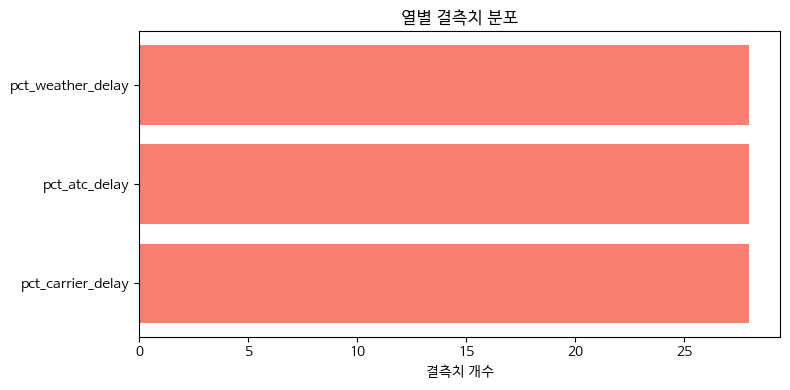

In [20]:
import matplotlib.pyplot as plt

# 결측치 있는 컬럼만 시각화
missing_df = missing_df[missing_df['Missing Count'] > 0]

plt.figure(figsize=(8, 4))
plt.barh(missing_df.index, missing_df['Missing Count'], color='salmon')
plt.xlabel('결측치 개수')
plt.title('열별 결측치 분포')
plt.tight_layout()
plt.show()

In [ ]:
# 항공사 별 중앙값으로 결측치 처리
df_group_filled = df.copy()
for col in ['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']:
    df_group_filled[col] = df_group_filled.groupby('airline')[col]\
                                          .transform(lambda x: x.fillna(x.median()))

In [17]:
# 수치형 변수만 추출
num_cols = ['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']
# 수치 비교를 위한 명칭수정
desc_group = df_group_filled[num_cols].add_prefix('group_')
# 원본 값과 결측치 처리한 값 비교
pd.concat([df, desc_group ],axis=1).describe()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,group_pct_carrier_delay,group_pct_atc_delay,group_pct_weather_delay
count,33440.000000,33440.000000,33440.000000,33468.000000,33468.000000,33468.000000
mean,7.041475,5.089962,0.684776,7.040845,5.089187,0.684473
std,4.497596,4.718647,1.073743,4.495832,4.716795,1.073355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.145455,2.146565,0.000000,4.147084,2.148281,0.000000
50%,6.356893,3.900000,0.316002,6.357260,3.900299,0.316002
75%,9.140474,6.630238,0.935161,9.136141,6.625000,0.934579
max,100.000000,100.000000,33.333333,100.000000,100.000000,33.333333


결론 : 원본값과 결측치를 처리한 값을 비교했을때 차이가 미약하므로 항공사별 중앙값으로 처리한 값을 사용

## 3. 탐색적 데이터 분석 (EDA)

### 3.1 변수별 분포
- 히스토그램 시각화

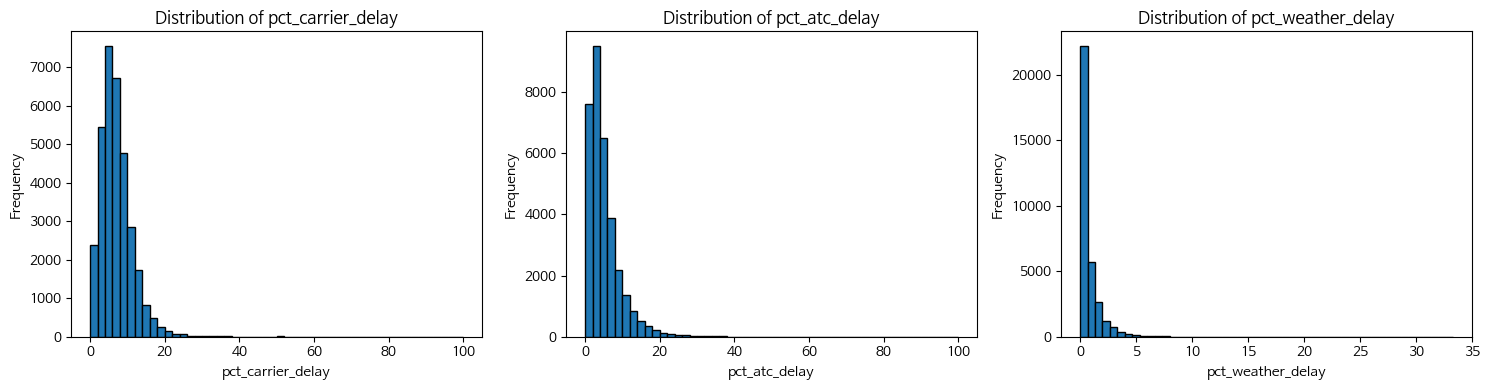

In [25]:
features = ['pct_carrier_delay', 'pct_atc_delay', 'pct_weather_delay']
plt.figure(figsize=(15, 4))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=50, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

- 날씨로 인해 지연될 확률은 0%에 몰려있으므로 날씨는 지연요인으로서 큰 영향을 미치지 않는것으로 보임

### 3.2 항공사별 비교

In [34]:
#항공사별 기술 통계
df.groupby('airline').describe().T

airline                       Alaska     American        Delta     Jet Blue  \
pct_carrier_delay count  3851.000000  5723.000000  9095.000000  3773.000000   
                  mean      3.521889     9.042180     6.333460     8.081843   
                  std       2.483224     4.139067     4.695292     3.797737   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       1.935484     6.338538     3.813989     5.341176   
                  50%       3.225806     8.428571     5.548387     7.657895   
                  75%       4.685599    10.988763     7.821952    10.280000   
                  max      22.290323    50.000000   100.000000    28.000000   
pct_atc_delay     count  3851.000000  5723.000000  9095.000000  3773.000000   
                  mean      5.472672     5.993529     4.462978     7.345231   
                  std       5.699303     4.647170     4.364335     5.227372   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       1.878614     3.108403     1.818182     3.784314   
                  50%       3.776860     4.986523     3.508108     6.136905   
                  75%       7.001330     7.594450     5.839901     9.612903   
                  max      54.838710    60.000000   100.000000    40.986111   
pct_weather_delay count  3851.000000  5723.000000  9095.000000  3773.000000   
                  mean      0.513497     1.122920     0.680765     0.465327   
                  std       1.136494     1.097811     1.093255     0.764147   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       0.000000     0.296719     0.000000     0.000000   
                  50%       0.000000     0.884354     0.316406     0.157312   
                  75%       0.497395     1.641725     0.893346     0.666667   
                  max      14.633803    12.500000    20.500000     9.923077   

airline                    Southwest       United  
pct_carrier_delay count  5584.000000  5414.000000  
                  mean      7.521997     7.398833  
                  std       3.345085     5.369283  
                  min       0.000000     0.000000  
                  25%       5.070294     4.034708  
                  50%       6.960930     6.445210  
                  75%       9.354839     9.633110  
                  max      24.800000   100.000000  
pct_atc_delay     count  5584.000000  5414.000000  
                  mean      3.147019     5.348133  
                  std       2.513162     4.992464  
                  min       0.000000     0.000000  
                  25%       1.612527     2.431308  
                  50%       2.559242     4.353647  
                  75%       3.790421     7.030109  
                  max      21.542722   100.000000  
pct_weather_delay count  5584.000000  5414.000000  
                  mean      0.512611     0.680697  
                  std       0.649631     1.338433  
                  min       0.000000     0.000000  
                  25%       0.105675     0.000000  
                  50%       0.305598     0.263780  
                  75%       0.663306     0.861395  
                  max       6.240987    33.333333

C:\Users\Admin\AppData\Local\Temp\ipykernel_9912\426218581.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes.boxplot(x=


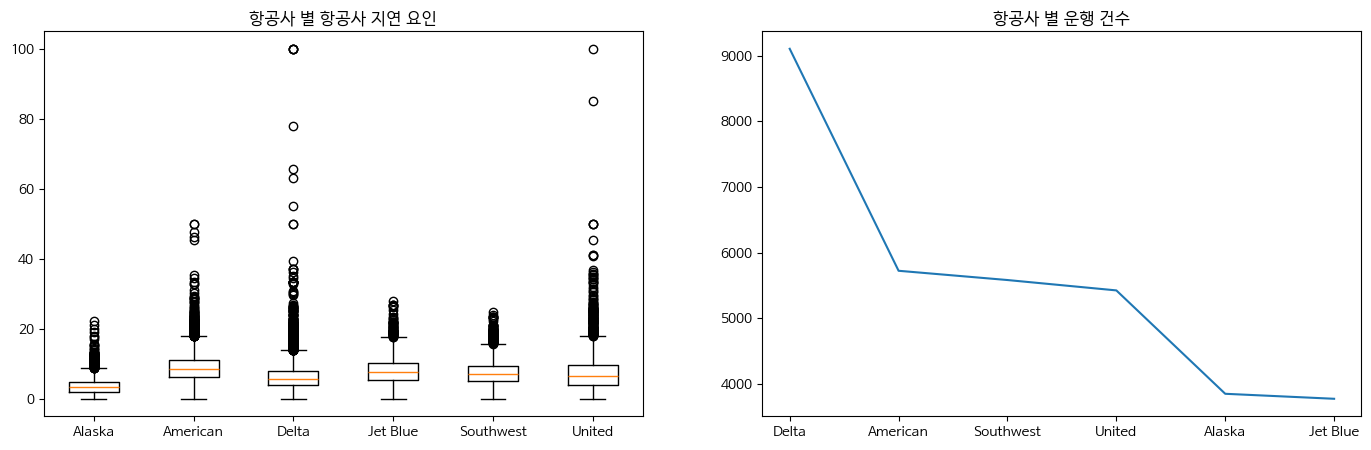

In [26]:
fig = plt.figure(figsize=[17,5])
axes = fig.add_subplot(1,2,1)
axes2 = fig.add_subplot(1,2,2)
axes.boxplot(x=
             [df_group_filled[df_group_filled['airline'] == 'Alaska']['pct_carrier_delay'],
             df_group_filled[df_group_filled['airline'] == 'American']['pct_carrier_delay'],
             df_group_filled[df_group_filled['airline'] == 'Delta']['pct_carrier_delay'],
             df_group_filled[df_group_filled['airline'] == 'Jet Blue']['pct_carrier_delay'],
             df_group_filled[df_group_filled['airline'] == 'Southwest']['pct_carrier_delay'],
             df_group_filled[df_group_filled['airline'] == 'United']['pct_carrier_delay']],
             labels=['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United'])
axes2.plot(df_group_filled['airline'].value_counts())
axes.set_title("항공사 별 항공사 지연 요인")
axes2.set_title("항공사 별 운행 건수")
plt.show()

- 전체적으로 운행 건수가 적을수록 항공사 지연 요인의 이상치가 적고 안정적인것을 알 수 있다.
- 이 중 United가 운행 건수에 비해 이상치가 높고 많은데 이는 United항공사가 불안정하다는것을 나타내는 지표로 보인다.
- Southwest의 경우 United보다 운행 건수가 많은데도 수치가 안정적이다.

C:\Users\Admin\AppData\Local\Temp\ipykernel_9912\367100303.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes.boxplot(x=
C:\Users\Admin\AppData\Local\Temp\ipykernel_9912\367100303.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes2.boxplot(x=


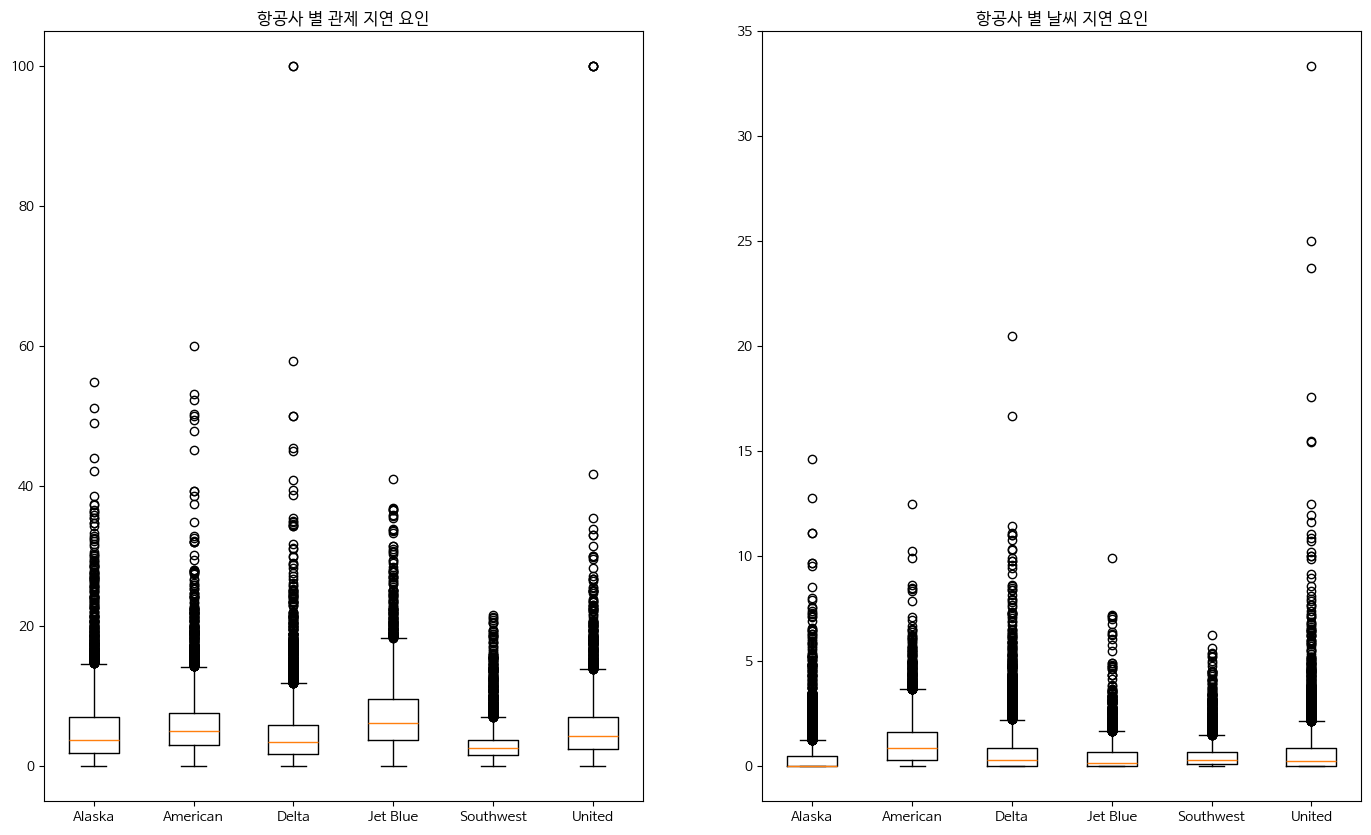

In [33]:
fig = plt.figure(figsize=[17,10])
axes = fig.add_subplot(1,2,1)
axes2 = fig.add_subplot(1,2,2)
axes.boxplot(x=
             [df_group_filled[df_group_filled['airline'] == 'Alaska']['pct_atc_delay'],
             df_group_filled[df_group_filled['airline'] == 'American']['pct_atc_delay'],
             df_group_filled[df_group_filled['airline'] == 'Delta']['pct_atc_delay'],
             df_group_filled[df_group_filled['airline'] == 'Jet Blue']['pct_atc_delay'],
             df_group_filled[df_group_filled['airline'] == 'Southwest']['pct_atc_delay'],
             df_group_filled[df_group_filled['airline'] == 'United']['pct_atc_delay']],
             labels=['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United'])
axes2.boxplot(x=
             [df_group_filled[df_group_filled['airline'] == 'Alaska']['pct_weather_delay'],
             df_group_filled[df_group_filled['airline'] == 'American']['pct_weather_delay'],
             df_group_filled[df_group_filled['airline'] == 'Delta']['pct_weather_delay'],
             df_group_filled[df_group_filled['airline'] == 'Jet Blue']['pct_weather_delay'],
             df_group_filled[df_group_filled['airline'] == 'Southwest']['pct_weather_delay'],
             df_group_filled[df_group_filled['airline'] == 'United']['pct_weather_delay']],
             labels=['Alaska', 'American', 'Delta', 'Jet Blue', 'Southwest', 'United'])
axes.set_title('항공사 별 관제 지연 요인')
axes2.set_title('항공사 별 날씨 지연 요인')
plt.show()

- 관제 지연 요인과 날씨 지연요인의 경우 역시 Southwest가 가장 안정적임을 알 수 있다.
- United 항공사 역시 위의 두 경우에서 지연 확률이 높음을 알 수 있다.

## 4. 2차원 데이터 분석

### 상관계수 분석

In [28]:
# 각 지연 요인간에는 상관계수가 낮음을 알 수 있다
df_group_filled.corr(numeric_only=True)

,pct_carrier_delay,pct_atc_delay,pct_weather_delay
pct_carrier_delay,1.000000,0.144515,0.161519
pct_atc_delay,0.144515,1.000000,0.091778
pct_weather_delay,0.161519,0.091778,1.000000


## 5. 인사이트 도출

- 운항사 지연율이 가장 높은 항공사는 운행 횟수 대비 항공사 지연 요인율이 높은 United 항공사인것으로 보임
- 관제 지연 요인율과 날씨 지연 요인율 역시 United가 높은 편인것으로 보아 United 항공사에 무언가 개선이 필요해 보임
- 전체적으로 봤을 때 운행 횟수가 많은 대형 항공사일수록 지연율 역시 높아지는것으로 보인다.

본 분석 결과, 항공 운항 지연의 주요 요인은 운항사 지연, 관제 지연, 기상 지연으로 파악되었으며, 각 요인 간의 상관관계는 낮은 것으로 나타났습니다. 특히, United 항공사는 운항사 지연뿐만 아니라 관제 지연 및 기상 지연에서도 타 항공사에 비해 높은 지연율을 보여 전반적인 운영 효율성 개선이 시급한 것으로 분석되었습니다. 이는 United 항공사의 지연이 특정 요인에 국한되지 않고, 전반적인 운영 시스템 및 외부 환경 대응 능력에서 취약점을 보이고 있음을 시사합니다.

## 6. 결론 및 제언

United 항공사의 전반적인 운항 지연 문제 해결을 위해 다음과 같은 다각적인 접근을 제언합니다.

1. 운항사 지연 개선을 위한 내부 시스템 강화:
- 승무원 및 항공기 스케줄 최적화 시스템 도입: AI 기반의 스케줄링 시스템을 통해 갑작스러운 변동에도 유연하게 대응하고, 승무원 피로도 관리를 통한 휴먼 에러를 최소화해야 합니다.
- 예비 항공기 및 정비 인력 확충: 예상치 못한 기체 결함이나 운항 지연 발생 시 즉각적으로 투입 가능한 예비 자원을 확보하여 지연 시간을 최소화해야 합니다.
- 정비 프로세스 효율화: 사전 예측 정비 시스템 도입 및 정비 인력의 전문성 강화를 통해 정비로 인한 지연을 줄여야 합니다.

2. 외부 요인(관제, 기상) 대응 능력 향상:
- 관제탑과의 실시간 정보 공유 및 협력 강화: 관제 당국과의 긴밀한 협업을 통해 항공기 흐름을 예측하고, 혼잡 시간대에 대한 사전 대응 전략을 수립해야 합니다.
- 기상 악화 시 대응 매뉴얼 고도화: 악천후 발생 시 승객 안내, 대체 항공편 및 숙소 제공 등 신속하고 체계적인 대응 매뉴얼을 정립하여 고객 불편을 최소화하고 2차 지연 발생을 방지해야 합니다.

3. 데이터 기반 의사결정 체계 구축:
- 지연 관련 데이터를 지속적으로 수집하고 분석하여 지연 원인을 세분화하고, 예측 모델을 고도화하여 예방 중심의 운영 체계로 전환해야 합니다.

이러한 개선 노력을 통해 United 항공사는 운항 지연율을 낮추고, 고객 만족도를 향상하며, 장기적으로는 운영 비용 절감 및 브랜드 이미지 제고에 기여할 수 있을 것입니다.